In [1]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, data_aug_knn, perform_eval, gp_regressor, data_aug_gp
from modelval.ArbDataGen import arb_w_gen, data_Gen, arb_spk_gen
from modelval.spk_visu import spk_see, raster
from modelval.kernel import KernelGen
import datajoint as dj
from sklearn.model_selection import train_test_split
import warnings
import modelval.model_validation_schema as vali
import modelval.pipeline_schema as pipe
import modelval.hyper_search_hippo_schema as hyperpr

import warnings

warnings.filterwarnings("ignore")

% matplotlib inline
%load_ext autoreload
    
%autoreload 2

Connecting shuang@10.28.0.34:3306


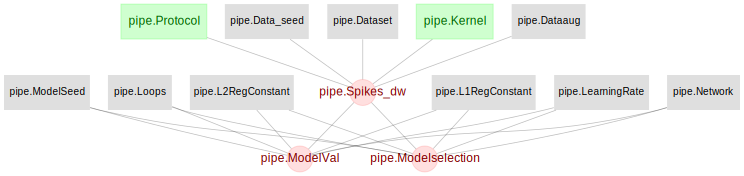

In [2]:
dj.ERD(pipe)

In [3]:
pipe.Protocol()

ptl_index Index for each protocol,ptl_idx Type of protocol,pre_spk_num Number of presynatpic spike,pre_spk_freq Frequency of presynaptic spike,post_spk_num Number of postsynaptic spike,post_spk_freq Frequency of postsynaptic spike,ptl_occ Number of protocol repitition,ptl_freq Frequency of protocol,dt1 pre-post time difference in ms,dt2 pre-pre time difference in ms,dt3 post-post time difference in ms,dw_mean change in w or mean change in w,dw_ste std change in w,train_len length of spike train
1,1,1,0,1,0,60,1,-102.898,0.0,0.0,-1.32259,0.0,60
2,1,1,0,1,0,60,1,-75.5799,0.0,0.0,2.67477,0.0,60
3,1,1,0,1,0,60,1,-80.8715,0.0,0.0,-12.6964,0.0,60
4,1,1,0,1,0,60,1,-67.5622,0.0,0.0,0.231446,0.0,60
5,1,1,0,1,0,60,1,-63.5534,0.0,0.0,-0.990216,0.0,60
6,1,1,0,1,0,60,1,-64.7826,0.0,0.0,-6.24986,0.0,60
7,1,1,0,1,0,60,1,-43.9356,0.0,0.0,-12.3596,0.0,60


In [4]:
# Read data from table to dataframe
data = pd.DataFrame((pipe.Protocol).fetch())
data.drop('ptl_index', inplace=True, axis=1)

In [16]:
data[data['ptl_idx'] == 2]

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
45,2,2,0,1,0,60,1,-10.0,10.0,0.0,27.153600,0.0,60
46,2,2,0,1,0,60,1,-10.0,10.0,0.0,15.282400,0.0,60
47,2,2,0,1,0,60,1,-10.0,10.0,0.0,14.312400,0.0,60
48,2,2,0,1,0,60,1,-10.0,10.0,0.0,-10.074400,0.0,60
49,2,2,0,1,0,60,1,-10.0,10.0,0.0,-11.598600,0.0,60
50,2,2,0,1,0,60,1,-10.0,10.0,0.0,11.125700,0.0,60
51,2,2,0,1,0,60,1,-10.0,10.0,0.0,8.077300,0.0,60
52,2,2,0,1,0,60,1,-10.0,10.0,0.0,2.119160,0.0,60
53,2,2,0,1,0,60,1,-10.0,10.0,0.0,0.733547,0.0,60
54,2,2,0,1,0,60,1,-10.0,10.0,0.0,-5.155310,0.0,60


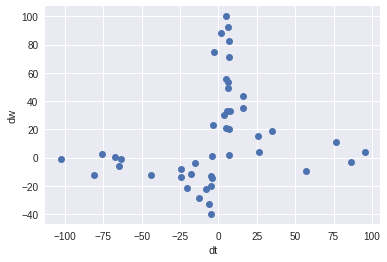

In [5]:
# Demostrate protocol
ptl_choice = 1

data_ptl1 = data[data['ptl_idx']==ptl_choice]

dt = data_ptl1['dt1']
dw = data_ptl1['dw_mean']
plt.plot(dt, dw, 'o')
plt.xlabel('dt')
plt.ylabel('dw')

In [6]:
kernel = KernelGen()
kernel.reso_kernel = 2
ptl_list = [ptl_choice]
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / kernel.reso_kernel)
spk_pairs, _ = arb_w_gen(df=data_ptl1, ptl_list=ptl_list, spk_len=spk_len, kernel=kernel, aug_times=[5], output_target=False)

In [7]:
pre_spike, post_spike = spk_see(ptl_type=ptl_choice, spk_pairs=spk_pairs[:,:-2,:])

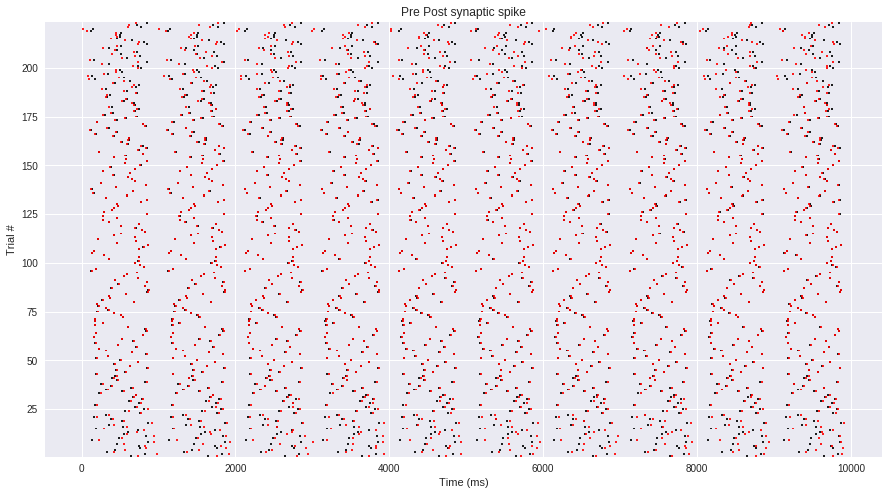

In [8]:
fig = plt.figure(figsize=(15, 8))
length = np.arange(0,10)
ax = raster(pre_spike, length)
ax = raster(post_spike, length, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
fig.show()

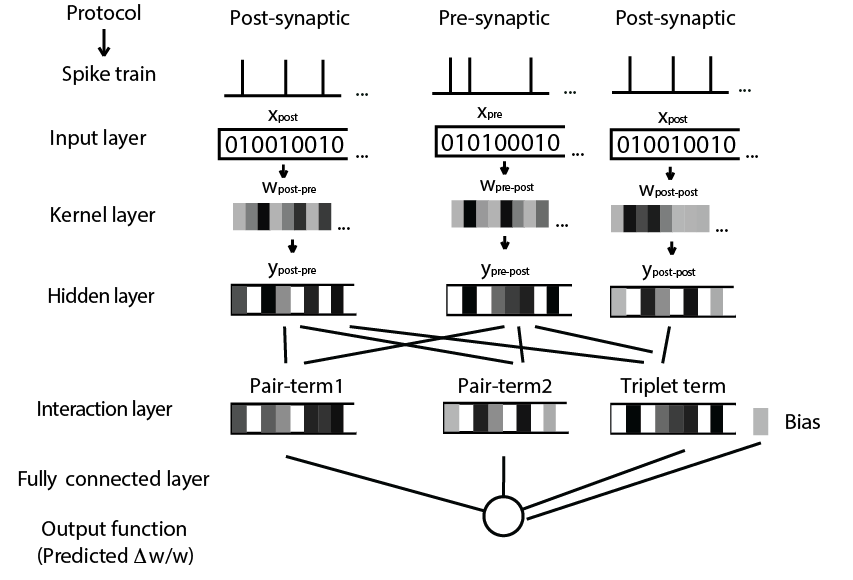

In [9]:
# Network
from IPython.display import Image
Image(filename='/data/TripNet.png', width=700, height=700)

In [10]:
pipe.Kernel()

kernel_id id for kernel,a_fast a fast,a_slow a_slow,a_fast_ a_fast2,a_slow_ a_slow2,tau_fast tau_fast,tau_slow tau_slow,tau_fast_ tau_fast_2,tau_slow_ tau_slow2
1,0.0061,0.0014,0.0016,0.0067,16.8,946.0,33.7,27.0
2,0.0053,0.0,0.0035,0.008,16.8,1.0,33.7,40.0
3,0.0,0.0,0.008,0.05,16.8,1.0,33.7,40.0
4,8.8e-11,0.0031,0.0066,0.053,16.8,714.0,33.7,40.0


1.0 1.0


array([ 0.00983431,  0.00344706,  2.15023217])

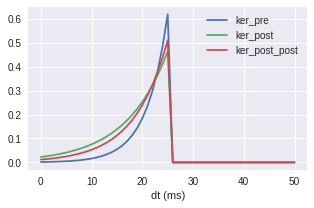

In [11]:
# Ground truth exponential decay kernel
kernel_df = pd.DataFrame((pipe.Kernel).fetch())
kernel_df.drop('kernel_id', inplace=True, axis=1)

plt.figure(figsize=(5,3))
ker_test = KernelGen()

para = kernel_df.iloc[0]

ker_test = KernelGen(len_kernel=51, len_trip=51)
ker_test.trip_model_ker(para, data_name='Hippocampus')
plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.plot(ker_test.kernel_post_post, label='ker_post_post')
plt.xlabel('dt (ms)')
plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2))
ker_test.kernel_scale

In [12]:
# Validation
vali.ModelSelection()

network_id l1 regularization id,dataset_id l1 regularization id,l1_id l1 regularization id,l2_id l1 regularization id,iterations number of iterations,lr_id,"random_start 1 if random start, 0 if start from ground truth, seed is ignored when 0",seed random seed,pre_kernel presynaptic kernel,post_kernel postsynaptic kernel,post_post_kernel postsynaptic kernel for higher order interaction,val_error mse on validation set,val_loss total loss on validation set,scale weight for output layer
0,0,0,0,5,1,0,0,=BLOB=,=BLOB=,=BLOB=,6.9108e-15,7.01242e-15,=BLOB=
0,1,0,0,5,1,0,0,=BLOB=,=BLOB=,=BLOB=,1.46601e-15,1.47879e-15,=BLOB=
0,2,0,0,5,1,0,0,=BLOB=,=BLOB=,=BLOB=,3.92774e-16,5.54893e-16,=BLOB=
1,0,0,0,5,1,0,0,=BLOB=,=BLOB=,=BLOB=,6.57126e-16,6.66491e-16,=BLOB=
1,1,0,0,5,1,0,0,=BLOB=,=BLOB=,=BLOB=,2.83218e-13,7.51116e-13,=BLOB=
1,2,0,0,5,1,0,0,=BLOB=,=BLOB=,=BLOB=,1.15298e-12,1.16691e-12,=BLOB=


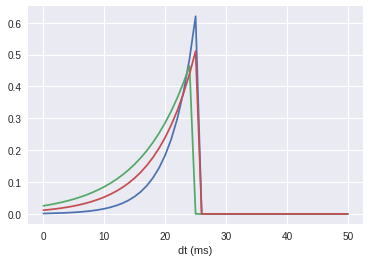

In [13]:
model = vali.ModelSelection() & 'network_id=1'  & 'dataset_id = 1'
# python magic
pre_kernel, post_kernel, post_post_kernel = map(np.squeeze, map(np.abs, model.fetch1('pre_kernel','post_kernel', 'post_post_kernel')))
plt.plot(pre_kernel)
plt.plot(post_kernel)
plt.plot(post_post_kernel)
plt.xlabel('dt (ms)')
plt.legend()

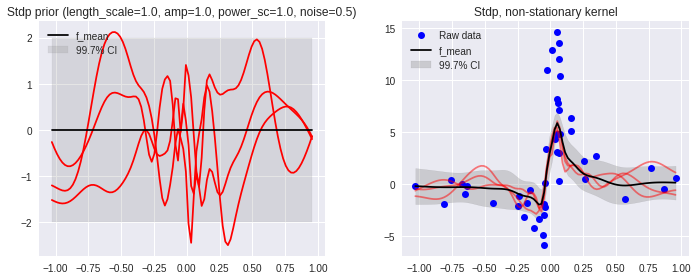

In [14]:
# Data augmentation
# Hand pick Amplitude

params_stdp  = {
    'length_scale': 0.1,
    'power_sc':1,
    'amp_kernel':1,
    'sigma_noise':2,
}

fig, ax = plt.subplots(1,2,sharex=True, sharey=False)
fig.set_figwidth(10)
fig.set_figheight(4)

x = np.array(data_ptl1['dt1']).reshape(-1,1)/100
std_stdp = data_ptl1[np.abs(data_ptl1['dt1'])>50]['dw_mean'].std()
y = np.array(data_ptl1['dw_mean']).reshape(-1,1)/std_stdp

x_test = np.linspace(np.min(x),np.max(x),100).reshape(-1,1)
prior_rg = gp_regressor.GP_regressor(x_test=x_test,  **params_stdp)
f,v_f,lg = prior_rg.fit()

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution

y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[0].plot(x_test,y_samp, 'r')
ax[0].set_title('Stdp prior (length_scale=%0.1f, amp=%0.1f, power_sc=%0.1f, noise=%0.1f)'%(1,1,1,0.5))

ax[0].plot(x_test, f, 'k', label='f_mean')
ax[0].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.2, color='gray', label='99.7% CI')
ax[0].legend(loc='upper left')
## ------------------------------------------------
prior_rg = gp_regressor.GP_regressor(x=x, y=y, x_test=x_test,  **params_stdp)
f,v_f,lg = prior_rg.fit(y_bias=0)

std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Sample from the distribution
ax[1].plot(x,y,"bo", label='Raw data')

y_samp = prior_rg.sample(n_samples=3, seed=2)
ax[1].plot(x_test,y_samp, 'r', alpha=0.5)
ax[1].set_title('Stdp, non-stationary kernel')

ax[1].plot(x_test, f, 'k', label='f_mean')
ax[1].fill_between(np.squeeze(x_test), np.squeeze(f-2*std), np.squeeze(f+2*std), alpha=0.3, color='gray', label='99.7% CI')
ax[1].legend(loc='upper left')
plt.tight_layout()

In [15]:
# Obtain augmented data from STDP protocol
params = {'amp_kernel': 1,
 'length_scale': 0.1,
 'power_sc': 0.2,
 'sigma_noise': 1.0}

x_stdp, f_stdp, x_stdp_test, y_stdp_test, _ = data_aug_gp.stdp_gp(data, test_fold=0, **params)

x_stdp_train, x_stdp_vali, y_stdp_train, y_stdp_vali = train_test_split(x_stdp, f_stdp, test_size=0.2)

[-110, 110, -50, 110]

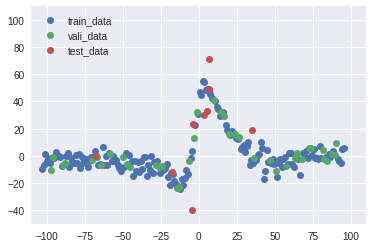

In [16]:
plt.plot(x_stdp_train, y_stdp_train, 'o',label='train_data')
plt.plot(x_stdp_vali, y_stdp_vali, 'o',label='vali_data')
plt.plot(x_stdp_test,y_stdp_test, 'o', label='test_data')
plt.legend(loc='upper left')
plt.axis([-110,110,-50,110])

In [37]:
# Generate cv for training and validation data given the test fold
data_gen_train, data_gen_vali, data_gen_test, y_train, y_vali, y_test = data_Gen(data, data_aug='gp_mean', test_fold_num=0)

In [18]:
# vali_err = np.zeros(len(data_gen_train))
# kernel_pre = []
# kernel_post = []
# kernel_post_post = []
# fc_w = []
# bias = []
# scale = []

# for i in range(len(data_gen_train)):
    
#     len_kernel = 101
#     len_trip = 151
#     ker_test = KernelGen(len_kernel=len_kernel, len_trip=len_trip)
    
#     # Generat the spike trains and targets for STDP
#     data_hippo = data[data['ptl_idx']<5]
#     ptl_list = [1,2,3,4]
#     spk_len = int(data_hippo['train_len'].max() * 1000 / ker_test.reso_kernel)
#     if_noise = 0
#     aug_times = [1,1,1,1]
#     spk_pairs_train, targets_train = arb_w_gen(df=data_gen_train[i], ptl_list=ptl_list, targets=y_train[i], if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times, seed=723)
#     spk_pairs_vali, targets_vali = arb_w_gen(df=data_gen_vali[i], ptl_list=ptl_list, targets=y_vali[i], if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times, seed=606)
    
#     # Create the network
#     ground_truth_init = 0
#     reg_scale=(10,50,100,200)
#     init_seed=(4,5,6,7,8)

#     toy_data_net = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, reg_scale=reg_scale, n_input=spk_pairs_train.shape[1])
    
#     # Create the trainer
#     save_dir= '/src/Plasticity_Ker/model/Pipeline_demo' + str(i)
#     toy_net_trainer = trainer.Trainer(toy_data_net.mse, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})
    
#     # Package the data
#     train_data = dataset.Dataset(spk_pairs_train, targets_train)
#     vali_data = dataset.Dataset(spk_pairs_vali, targets_vali)
    
#     # Learn the kernel from random initialization
#     learning_rate = 0.001
#     iterations = 5
#     min_error = -1
#     for _ in range(iterations):
#         mini_vali_loss = toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
#         learning_rate = learning_rate/3
 
#     vali_err[i] = mini_vali_loss
#     toy_net_trainer.restore_best()
#     kernel_pre.append(toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre))
#     kernel_post.append(toy_net_trainer.evaluate(ops=toy_data_net.kernel_post))
#     kernel_post_post.append(toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post))
#     fc_w.append(toy_net_trainer.evaluate(ops=toy_data_net.fc_w))
#     bias.append(toy_net_trainer.evaluate(ops=toy_data_net.bias))
#     scale.append(toy_net_trainer.evaluate(ops=toy_data_net.scaler))

In [38]:
hyperpr.ModelSelection()

network_id id for type of network,dataset_id id for type of dataset,dataaug_id data augmentation strategy name,l1_id l1 regularization id,l2_id l2 regularization id,sm_lp_id laplacian filter smoothing id,sm_hm_id Hamming window smoothness id,iterations number of iterations,lr_id,"random_start 1 if random start, 0 if start from ground truth, seed is ignored when 0",seed random seed,pre_kernel presynaptic kernel,post_kernel postsynaptic kernel,post_post_kernel postsynaptic kernel for higher order interaction,val_error mse on validation set,bias bias of the output layer,scale weight for output layer,fc_w fully connected weights
1,1,0,0,0,0,0,5,1,1,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
1,1,0,0,0,0,0,5,1,1,100,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
1,1,0,0,0,0,2,5,1,1,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
1,1,0,0,0,0,2,5,1,1,100,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
1,1,0,0,0,0,3,5,1,1,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
1,1,0,0,0,0,3,5,1,1,100,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
1,1,0,1,0,0,1,5,1,1,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [39]:
# Retrieve the one with the best performance
hyperparameter_df = pd.DataFrame(hyperpr.ModelSelection().fetch())
hyperparameter_df['mean_val_err'] = hyperparameter_df['val_error'].map(lambda x: x.mean())
selected_model = hyperparameter_df.sort(columns='mean_val_err').iloc[0]

In [40]:
selected_model

network_id                                                          1
dataset_id                                                          1
dataaug_id                                                          1
l1_id                                                               0
l2_id                                                               0
sm_lp_id                                                            0
sm_hm_id                                                            0
iterations                                                          5
lr_id                                                               1
random_start                                                        1
seed                                                              100
pre_kernel          [[[-0.00170916], [0.0114873], [0.00453806], [0...
post_kernel         [[[0.0205233], [0.000808964], [0.0206837], [0....
post_post_kernel    [[[0.000194777], [-0.000121918], [0.000140058]...
val_error           

In [41]:
# Updated the kernel as trained kernel
select_cv = 0
ker_test.kernel_pre = selected_model['pre_kernel'][select_cv]
ker_test.kernel_post =  selected_model['post_kernel'][select_cv]
ker_test.kernel_post_post=  selected_model['post_post_kernel'][select_cv]
ker_test.kernel_scale =  selected_model['fc_w'][select_cv]
ker_test.bias =  selected_model['bias'][select_cv]
ker_test.scale = selected_model['scale'][select_cv]

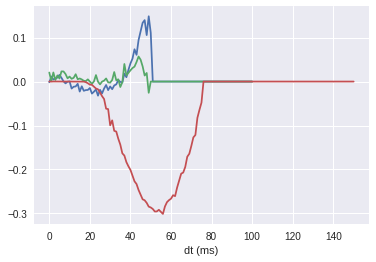

In [42]:
plt.plot(ker_test.kernel_pre )
plt.plot(ker_test.kernel_post)
plt.plot(ker_test.kernel_post_post)
plt.xlabel('dt (ms)')
plt.legend()

In [47]:
# Generat the spike trains and targets for STDP
ptl_list = [1,2,3,4]
spk_len = int(data['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 0
aug_times = [1,1,1,1]

fold=2
ker_test.len_kernel = 101
ker_test.len_trip = 151

spk_pairs_test, _ = arb_w_gen(df=data_gen_vali[fold], ptl_list=ptl_list, targets=y_vali[fold], if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

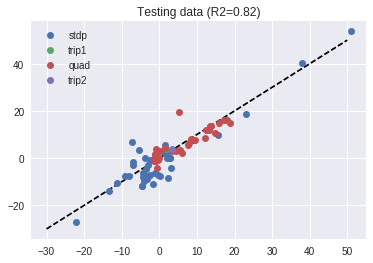

In [48]:
# Generate test predictions
y_test = y_vali[fold]
spk_len = int(data['train_len'].max() * 1000 / ker_test.reso_kernel)
_, predictions_test = arb_w_gen(spk_pairs=spk_pairs_test, spk_len=spk_len, kernel=ker_test, net_type='triplet')

# ptl_len = np.array([12,7,12,4])
ptl_len = np.array([40,1,40,1])
rep_time = np.array([1,1,1,1])
ptl_len, targets_out, predictions_out = data_aug_gp.target_pred_gen(y_test, predictions_test, ptl_len, rep_time)

# Calculate the total sum of squares
R2 = 1 - np.sum(np.square(predictions_test-y_test))/(np.square(np.std(y_test))*(len(y_test)-1))
corr = np.sqrt(R2)

plt.plot(np.linspace(-30,50,80), np.linspace(-30,50,80),'k--')
ptl_type = ['stdp', 'trip1', 'quad','trip2']
for i in range(len(ptl_len)):
    plt.plot(targets_out[i], predictions_out[i],'o', label=ptl_type[i])

plt.title('Testing data (R2=%0.2f)'%(R2))
plt.legend()